In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


In [235]:
df_train.head()


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [236]:
df_train["date"] = pd.to_datetime(df_train["date"])

In [237]:
df_train["product"].nunique()

5

In [238]:
df_train = df_train.dropna()

In [239]:
df_train.isna().value_counts()

id     date   country  store  product  num_sold
False  False  False    False  False    False       221259
Name: count, dtype: int64

# EDA

<Axes: xlabel='store', ylabel='num_sold'>

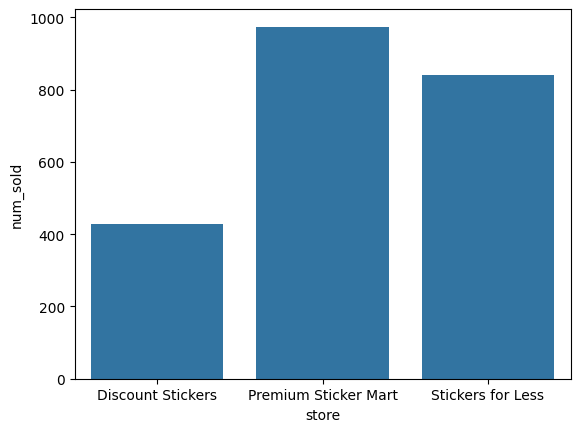

In [240]:
sns.barplot(df_train.groupby("store").agg({"num_sold": "mean"})["num_sold"])

<Axes: xlabel='country', ylabel='num_sold'>

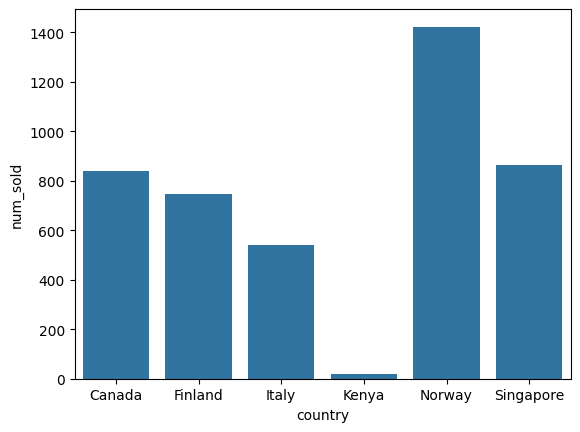

In [241]:
sns.barplot(df_train.groupby("country").agg({"num_sold": "mean"})["num_sold"])

<Axes: xlabel='product', ylabel='num_sold'>

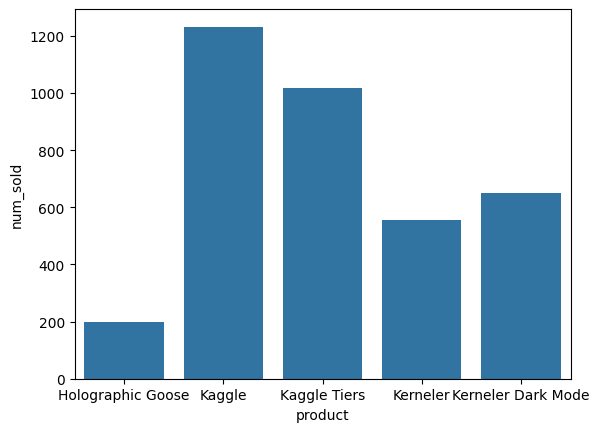

In [242]:
sns.barplot(df_train.groupby("product").agg({"num_sold": "mean"})["num_sold"])

<Axes: xlabel='date'>

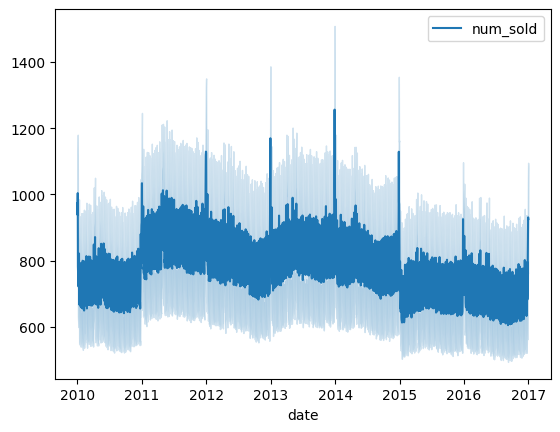

In [243]:
sns.lineplot(df_train[["date", "num_sold"]].set_index("date"))

In [244]:
df_train.head()

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


In [245]:
df_train["month"] = df_train["date"].dt.month
df_train["day"] = df_train["date"].dt.day
df_train["year"] = df_train["date"].dt.year

In [246]:
df_train = df_train.drop(labels=["date"], axis=1)

In [247]:
categorial_columns = list(df_train.select_dtypes(include="object").columns)

In [248]:
for col in categorial_columns:
    one_hot = pd.get_dummies(df_train[col], prefix=col, drop_first=True)
    df_train = pd.concat((df_train.drop(col, axis=1), one_hot), axis=1)
df_train = df_train.drop("id",axis=1)

In [249]:
df_train.head()

,num_sold,month,day,year,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
1,973.0,1,1,2010,False,False,False,False,False,False,False,True,False,False,False
2,906.0,1,1,2010,False,False,False,False,False,False,False,False,True,False,False
3,423.0,1,1,2010,False,False,False,False,False,False,False,False,False,True,False
4,491.0,1,1,2010,False,False,False,False,False,False,False,False,False,False,True
5,300.0,1,1,2010,False,False,False,False,False,False,True,False,False,False,False


In [250]:
X_train = df_train.drop("num_sold", axis=1)
y_train = df_train["num_sold"]

<Axes: >

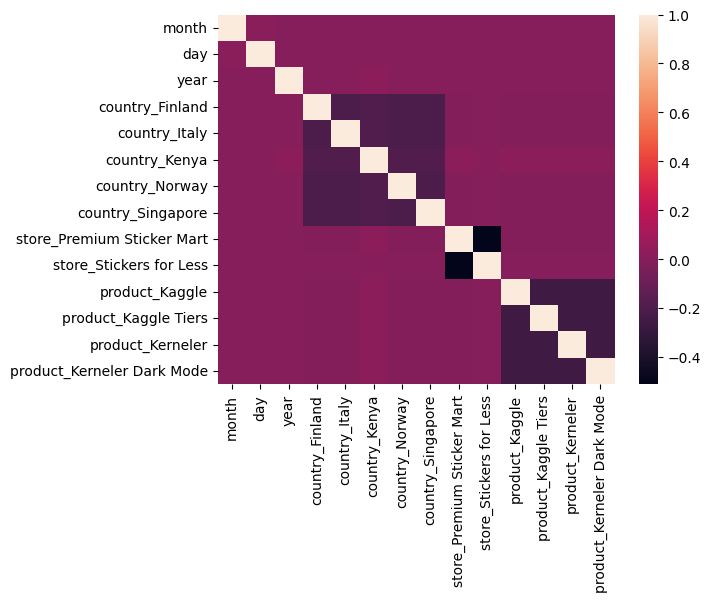

In [251]:
sns.heatmap(X_train.corr())

In [252]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline((("scaler", StandardScaler()),
                 ("Lasso", Lasso(2))))



In [253]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
train = []
test = []

tscv = TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_fold_train, X_fold_test = X_train.values[train_index], X_train.values[test_index]
    y_fold_train, y_fold_test = y_train.values[train_index], y_train.values[test_index]
    
    pipe.fit(X_fold_train, y_fold_train)
    train.append(mean_absolute_percentage_error(y_fold_train, pipe.predict(X_fold_train)))
    test.append(mean_absolute_percentage_error(y_fold_test, pipe.predict(X_fold_test)))

    


In [254]:
print("MAPE на train:", np.mean(train))
print("MAPE на test:", np.mean(test))


MAPE на train: 4.310121622697805
MAPE на test: 4.32015065144733


In [259]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

params = {
    "catboost__learning_rate": [0.001,0.01,0.1,0.2]
}

catpipe = Pipeline((("scaler", StandardScaler()),
                 ("catboost", CatBoostRegressor())))

grid = GridSearchCV(catpipe,param_grid=params)
grid.fit(X_train, y_train)



0:	learn: 693.1319296	total: 12.5ms	remaining: 12.5s
1:	learn: 692.5559580	total: 22.8ms	remaining: 11.4s
2:	learn: 691.9806587	total: 34.1ms	remaining: 11.3s
3:	learn: 691.4060311	total: 47.1ms	remaining: 11.7s
4:	learn: 690.8320745	total: 61ms	remaining: 12.1s
5:	learn: 690.2587882	total: 77.3ms	remaining: 12.8s
6:	learn: 689.6861718	total: 92ms	remaining: 13s
7:	learn: 689.1142244	total: 108ms	remaining: 13.4s
8:	learn: 688.5429456	total: 124ms	remaining: 13.6s
9:	learn: 687.9723348	total: 141ms	remaining: 13.9s
10:	learn: 687.4023911	total: 157ms	remaining: 14.1s
11:	learn: 686.8331142	total: 174ms	remaining: 14.3s
12:	learn: 686.2645033	total: 190ms	remaining: 14.5s
13:	learn: 685.6965579	total: 209ms	remaining: 14.7s
14:	learn: 685.1292772	total: 227ms	remaining: 14.9s
15:	learn: 684.5626608	total: 247ms	remaining: 15.2s
16:	learn: 683.9967079	total: 266ms	remaining: 15.4s
17:	learn: 683.4314180	total: 289ms	remaining: 15.8s
18:	learn: 682.8667904	total: 308ms	remaining: 15.9s
19

GridSearchCV(estimator=Pipeline(steps=(('scaler', StandardScaler()),
                                       ('catboost',
                                        <catboost.core.CatBoostRegressor object at 0x00000224679E5D00>))),
             param_grid={'catboost__learning_rate': [0.001, 0.01, 0.1, 0.2]})

In [260]:
grid.best_params_

{'catboost__learning_rate': 0.01}

In [262]:
catpipe.set_params(**{"catboost__learning_rate": 0.01})
cross = cross_validate(catpipe, X_train, y_train, cv = tscv,return_train_score=True, scoring="neg_mean_absolute_percentage_error")

0:	learn: 670.0635802	total: 20.2ms	remaining: 20.1s
1:	learn: 664.4383470	total: 36ms	remaining: 18s
2:	learn: 658.8780053	total: 46.2ms	remaining: 15.3s
3:	learn: 653.3819549	total: 53.7ms	remaining: 13.4s
4:	learn: 647.9496010	total: 61ms	remaining: 12.1s
5:	learn: 642.5803544	total: 67ms	remaining: 11.1s
6:	learn: 637.2736311	total: 72.4ms	remaining: 10.3s
7:	learn: 632.0288524	total: 77.2ms	remaining: 9.57s
8:	learn: 626.8454448	total: 81.3ms	remaining: 8.96s
9:	learn: 621.7228398	total: 85.6ms	remaining: 8.48s
10:	learn: 616.6604743	total: 89.7ms	remaining: 8.07s
11:	learn: 611.6577898	total: 93.6ms	remaining: 7.71s
12:	learn: 606.7142328	total: 98.4ms	remaining: 7.47s
13:	learn: 601.8292548	total: 103ms	remaining: 7.23s
14:	learn: 597.0023119	total: 106ms	remaining: 6.97s
15:	learn: 592.2328650	total: 110ms	remaining: 6.79s
16:	learn: 587.5203796	total: 114ms	remaining: 6.58s
17:	learn: 582.8643257	total: 118ms	remaining: 6.44s
18:	learn: 578.2641778	total: 122ms	remaining: 6.29

In [263]:
print("MAPE на train:", -np.mean(cross["train_score"]))
print("MAPE на test:", -np.mean(cross["test_score"]))

MAPE на train: 0.48415086939538765
MAPE на test: 0.638547044617389


In [293]:
from sklearn.ensemble import RandomForestRegressor

params_forest = {
    "forest__n_estimators": [10,20,30]
}
catforest = Pipeline((("scaler", StandardScaler()),
                 ("forest", RandomForestRegressor(n_estimators=20))))

grid = GridSearchCV(catforest,param_grid=params_forest)
grid.fit(X_train, y_train)
print(grid.best_params_)
catforest.set_params(**grid.best_params_)


{'forest__n_estimators': 30}


Pipeline(steps=(('scaler', StandardScaler()),
                ('forest', RandomForestRegressor(n_estimators=30))))

In [ ]:
cross_forest = cross_validate(catforest, X_train, y_train, cv = tscv,return_train_score=True, scoring="neg_mean_absolute_percentage_error")

In [270]:
print("MAPE на train:", -np.mean(cross_forest["train_score"]))
print("MAPE на test:", -np.mean(cross_forest["test_score"]))

MAPE на train: 0.02914092699308696
MAPE на test: 0.1205366664384782


In [294]:
from sklearn.metrics import mean_absolute_percentage_error

catforest.fit(X_train,y_train)
print(mean_absolute_percentage_error(y_train, catforest.predict(X_train)))

0.030403349507759247


# Submission

In [304]:
df_test = pd.read_csv("test.csv")

In [305]:
df_id = df_test["id"].copy()

In [306]:
df_test["date"] = pd.to_datetime(df_test["date"])

In [307]:
df_test["month"] = df_test["date"].dt.month
df_test["day"] = df_test["date"].dt.day
df_test["year"] = df_test["date"].dt.year

In [308]:
df_test = df_test.drop(["id","date"], axis=1)

In [309]:
for col in categorial_columns:
    one_hot = pd.get_dummies(df_test[col], prefix=col, drop_first=True)
    df_test = pd.concat((df_test.drop(col, axis=1), one_hot), axis=1)


In [300]:
df_test.head()

,month,day,year,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,1,1,2017,False,False,False,False,False,False,False,False,False,False,False
1,1,1,2017,False,False,False,False,False,False,False,True,False,False,False
2,1,1,2017,False,False,False,False,False,False,False,False,True,False,False
3,1,1,2017,False,False,False,False,False,False,False,False,False,True,False
4,1,1,2017,False,False,False,False,False,False,False,False,False,False,True


In [314]:
df_id

0        230130
1        230131
2        230132
3        230133
4        230134
          ...  
98545    328675
98546    328676
98547    328677
98548    328678
98549    328679
Name: id, Length: 98550, dtype: int64

In [313]:
pred = catforest.predict(df_test)
result = pd.concat([pd.DataFrame(df_id)
           ,pd.DataFrame(pred,columns=["num_sold"])], axis=1)
result.set_index("id").to_csv("submission.csv")

In [315]:
result

,id,num_sold
0,230130,146.533333
1,230131,710.466667
2,230132,645.733333
3,230133,334.066667
4,230134,402.533333
...,...,...
98545,328675,420.633333
98546,328676,2879.400000
98547,328677,2217.733333
98548,328678,1197.233333
